In [34]:
import numpy as np
from sklearn.datasets import make_blobs
import pandas as pd
import matplotlib.pyplot as plt

# Logistic Regression

In [2]:
# Dataset
X_org, y_org = make_blobs(n_samples=10000, n_features=50, centers=2)
# y_org = y_org[:, np.newaxis] #(10000,1)
X_org.shape, y_org.shape, X_org[0]

((10000, 50),
 (10000,),
 array([ -1.64696236,   9.01090797,  -1.98802147,   3.15233111,
          4.0968578 ,  -0.31496637,   9.38750768,  -6.42837045,
          1.42962762,  -3.91217189,   7.92913909,  -4.39952451,
          8.44815599,  -3.07259154,   8.11420031,  -8.8215984 ,
          5.12037187,   1.14821248,   8.732371  ,  -7.21743621,
          3.82449992,   1.70658374,  -3.67938881,   1.44851931,
          0.278591  ,  -1.54479365,  -6.47671786,   8.85149763,
          4.48864538,  -9.18381865,  -6.14643768,   1.57909819,
         -8.79125185,  -1.80473363,   7.00168712,  -5.17167082,
         -0.86552474, -10.04987864,  -1.32608066,   4.1283862 ,
          5.00128572,   7.74307333,  -8.72304822,   7.57489181,
          7.55145763,  -7.60251926,   4.2136229 ,  -5.4308731 ,
         -0.97963148,   3.44636361]))

# Feature Normalization
1. Subtract the mean value of each feature from the dataset.
2. After subtracting the mean, additionally scale (divide) the feature values by their resp. standard deviations.

In [3]:
X_org=(X_org - np.mean(X_org, axis=0))/np.std(X_org, axis=0)
X_org[0]

array([-0.78476679,  1.06769693,  0.47990452,  1.19198167,  0.71959579,
        1.13123695,  1.09017403, -0.75671711,  1.28782452,  0.30402438,
        1.13158043,  0.19764999,  1.2657986 , -0.09864014,  0.87545348,
       -1.09255284,  1.29040323,  1.25660511,  0.63472267, -0.78521233,
        0.96092757, -1.72195679, -1.03012402,  1.08734317, -1.56028428,
        0.43752889, -0.92710716,  1.18547887,  1.13566598, -1.03210694,
       -1.12983182, -0.07269722, -0.86839119, -1.01507089, -1.16230636,
       -0.78152797,  0.6767667 , -1.11106834, -0.91976262, -1.41440372,
       -0.52396353,  0.9607229 , -0.95215891,  0.93215995,  0.80291161,
       -0.85358927,  0.95452387, -0.67183686, -1.17591788, -1.06749541])

# Create Train - Test split

In [4]:
data = pd.concat([pd.DataFrame(X_org), pd.DataFrame(y_org)], axis=1)

# get train and test datasets
train_set = data.sample(frac=0.7, replace=False, random_state=42)

test_set = data.drop(train_set.index)

print(len(train_set), len(test_set))

X_train, y_train = train_set.iloc[:, :-1].to_numpy(), train_set.iloc[:, -1].to_numpy()
X_test, y_test = test_set.iloc[:, :-1].to_numpy(), test_set.iloc[:, -1].to_numpy()

# store 1's in the 0th column of dataset to add intercept term
ones = np.ones(shape=(X_train.shape[0], 1))
X_train = np.column_stack((ones, X_train))

ones = np.ones(shape=(X_test.shape[0], 1))
X_test = np.column_stack((ones, X_test))

# add 1 column to labels
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

7000 3000


((7000, 51), (7000, 1), (3000, 51), (3000, 1))

# Create Logistic Regression Class

In [29]:
class LogisticRegression():
    def __init__(self, features, lr):
        self.theta = np.zeros(shape=(features, 1))
        self.lr = lr
        return

    def forward(self, X):
        linear = np.dot(X, self.theta)
        return sigmoid(linear)

    def backward(self, X, y, y_hat):
        batch = y_hat.shape[0]
        # calculate gradients 
        dl_dtheta = (1/batch) * np.dot(X.T, (y_hat - y))
        
        self.theta -= self.lr * dl_dtheta
        return

def sigmoid(z):
    return 1 / (1+np.exp(-z))

def bce_loss(y, y_hat):
    batch = y_hat.shape[0]
    a = np.dot(y.T, np.log(y_hat))
    b = np.dot((1-y).T, np.log(1-y_hat))
    return (-1/batch) * (a + b)

# Import model and hyperparameters

In [30]:
epochs = 50
lr = 0.01
batch_size = 100
features = X_train.shape[1] # (m + 1)
x_train_batches = X_train.reshape(-1, batch_size, features)
y_train_batches = y_train.reshape(-1, batch_size, 1)

model = LogisticRegression(features, lr)
model.theta.shape

(51, 1)

# Training Pipeline

In [31]:
y_train_batches[0].shape, model.forward(x_train_batches[0]).shape, x_train_batches[0].shape

((100, 1), (100, 1), (100, 51))

In [32]:
train_loss = []
for epoch in range(epochs):
    batch_loss = 0.0
    for x_batch, y_batch in zip(x_train_batches, y_train_batches):
        # forward propagation
        y_hat = model.forward(X=x_batch) # (100, 1)

        # calculate loss
        cf = bce_loss(y=y_batch, y_hat=y_hat)
        batch_loss+=cf

        # backward propagation, calculate gradients, update weights
        model.backward(X=x_batch, y=y_batch, y_hat=y_hat)
    
    batch_loss = np.average(batch_loss)
    train_loss.append(batch_loss)

    if epoch%10==0:
        print(f'Batch BCE Loss = {round(batch_loss,2)} at epoch {epoch}/{epochs}')

Batch BCE Loss = 9.46 at epoch 0/50
Batch BCE Loss = 0.25 at epoch 10/50
Batch BCE Loss = 0.13 at epoch 20/50
Batch BCE Loss = 0.09 at epoch 30/50
Batch BCE Loss = 0.07 at epoch 40/50


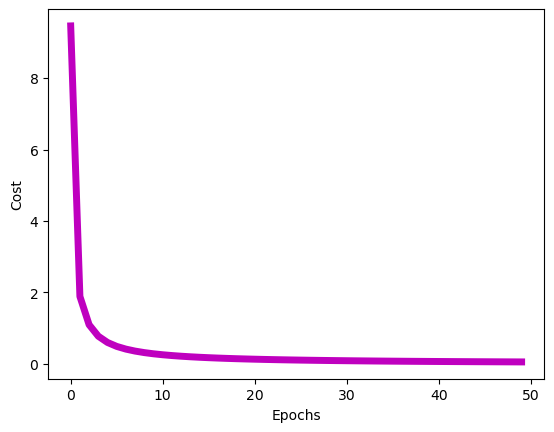

In [35]:
def plot_cost(loss, num_epochs):
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.plot(num_epochs, loss, 'm', linewidth='5')
    plt.show()

plot_cost(train_loss, range(epochs))

# Predict on Test data

In [43]:
def predict(x_test, y_test):
    # get trained model params
    prob = model.forward(x_test) # (3000, 1)

    # get class label
    y_pred = prob > 0.5

    correct_samples = np.sum(y_pred == y_test)
    total_samples = y_test.shape[0]

    accuracy = (correct_samples/total_samples)*100

    test_loss = bce_loss(y=y_test, y_hat=prob)

    tp, fp, tn, fn = 0, 0, 0, 0
    for gt, pred in zip(y_test, y_pred):
        gt, pred = int(gt),int(pred)
        if gt == pred==1:tp+=1
        elif gt==1 and pred==0:fn+=1
        elif gt==0 and pred==1:fp+=1
        else:tn+=1

    try:precision = tp/(tp+fp)
    except:precision = 1.0

    try:recall = tp/(tp+fn)
    except:recall = 1.0

    f1_score = 2*(precision*recall)/(precision + recall)

    print(f"Accuracy on test data : {accuracy}% and test bce loss : {test_loss[0][0]}")
    print(f"Precision : {precision}, Recall : {recall}, F1 score: {f1_score}")
    return

predict(X_test, y_test)

    

Accuracy on test data : 100.0% and test bce loss : 0.000775605002768876
Precision : 1.0, Recall : 1.0, F1 score: 1.0
